In [1]:
import tensorflow as tf
from pathlib import Path

In [2]:
filepath = tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)
if "_extracted" in filepath:
    ridership_path = Path(filepath) / "ridership"
else:
    ridership_path = Path(filepath).with_name("ridership")

108512/108512 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


path = Path("datasets/ridership_extracted/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df=pd.read_csv(path,parse_dates=["service_date"])
df.columns=["date","day_type","bus","rail","total"]
df=df.sort_values("date").set_index("date")
df=df.drop("total",axis=1)
df=df.drop_duplicates()

In [4]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


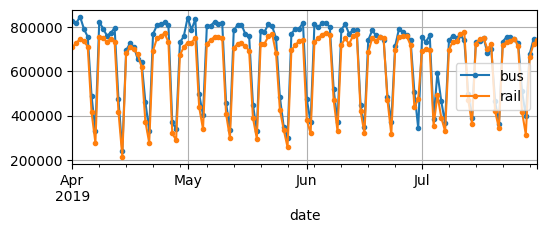

In [5]:
df["2019-04":"2019-7"].plot(grid=True,marker=".",figsize=(6,2))
plt.show()

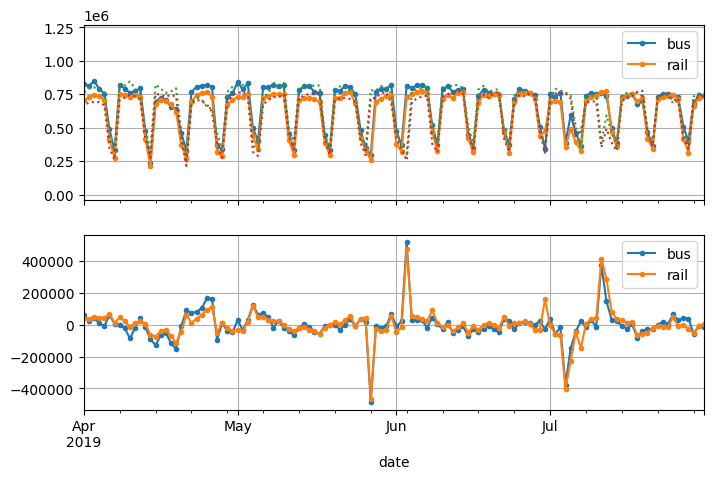

In [6]:
diff7=df[["bus","rail"]].diff(7)["2019-04":"2019-7"]
fig,axs=plt.subplots(2,1,sharex=True,figsize=(8, 5))
df.plot(ax=axs[0],marker=".")
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")
diff7.plot(ax=axs[1], grid=True, marker=".")
plt.show()

In [7]:
diff7.abs().mean()

,0
bus,52363.040984
rail,52586.377049


In [8]:
targets = df[["bus", "rail"]]["2019-04":"2019-07"]
(diff7 / targets).abs().mean()

,0
bus,0.093824
rail,0.104302


In [9]:
from statsmodels.tsa.arima.model import ARIMA

origin,today="2019-01-01", "2019-05-31"
rail_series=df.loc[origin:today]["rail"].asfreq("D")
model=ARIMA(
    rail_series,
    order=(1,0,0),
    seasonal_order=(0,1,1,7)
)
model=model.fit()
y_pred=model.forecast()

In [10]:
y_pred.iloc[0]

np.float64(427758.6262875742)

In [11]:
df["rail"].loc["2019-06-01"]

np.int64(379044)

In [12]:
df["rail"].loc["2019-05-25"]

np.int64(426932)

In [13]:
origin,start_date,end_date="2019-01-01", "2019-03-01", "2019-05-31"
time_period=pd.date_range(start_date,end_date)
rail_series=df.loc[origin:end_date]["rail"].asfreq("D")
y_preds=[]
for today in time_period.shift(-1):
    model=ARIMA(
        rail_series[origin:today],
        order=(1,0,0),
        seasonal_order=(0,1,1,7)
    )
    model=model.fit()
    y_pred=model.forecast().iloc[0]
    y_preds.append(y_pred)


In [14]:
y_preds=pd.Series(y_preds,index=time_period)
mae=(y_preds-rail_series[time_period]).abs().mean()
mae

np.float64(32040.72009292839)

In [15]:
def create_X_y(series,window_size,batch_size):
    X,y=[],[]
    for i in range (len(series)-window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])

    X=np.array(X)
    y=np.array(y)

    num_batches=int(np.ceil(len(X)/batch_size))
    X_batch=np.array_split(X,num_batches)
    y_batch=np.array_split(y,num_batches)

    return list(zip(X_batch,y_batch))

In [16]:
my_series=[0,1,2,3,4,5]
dataset=create_X_y(my_series,3,2)

In [17]:
dataset

[(array([[0, 1, 2],
         [1, 2, 3]]),
  array([3, 4])),
 (array([[2, 3, 4]]), array([5]))]

In [18]:
class TimeSeriesDatasetBuilder:
    def __init__(self,series,window_size=56,batch_size=32,shuffle=True,seed=42):
        self.series=np.array(series)
        self.window_size=window_size
        self.batch_size=batch_size
        self.shuffle=shuffle
        self.seed=seed

    def _create_X_y(self):
        X,y=[],[]
        for i in range(len(self.series) - self.window_size):
            X.append(self.series[i:i+self.window_size])
            y.append(self.series[i+self.window_size])

        return np.array(X),np.array(y)

    def get_tf_dataset(self):
        X,y=self._create_X_y()
        ds=tf.data.Dataset.from_tensor_slices((X,y))
        if self.shuffle:
            ds=ds.shuffle(buffer_size=len(self.series),seed=self.seed)
        ds=ds.batch(self.batch_size)
        ds=ds.prefetch(tf.data.AUTOTUNE)
        return ds

In [26]:
rail_train=df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid=df["rail"]["2019-01":"2019-05"] / 1e6
rail_test=df["rail"]["2019-06":] /1e6

In [27]:
rail_train.values

array([0.319835, 0.365509, 0.287661, ..., 0.307105, 0.26531 , 0.386058])

In [28]:
window_size=56

builder_train=TimeSeriesDatasetBuilder(
    series=rail_train.values,
    window_size=window_size,
    batch_size=32,
    shuffle=True,
    seed=42
)
builder_valid=TimeSeriesDatasetBuilder(
    series=rail_valid.values,
    window_size=window_size,
    batch_size=32
)

In [34]:
train_ds=builder_train.get_tf_dataset()
valid_ds=builder_valid.get_tf_dataset()

In [35]:
model=tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])
early_stopping_cb=tf.keras.callbacks.EarlyStopping(monitor="val_mae",
                                                  patience=30,
                                                  restore_best_weights=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=tf.keras.losses.Huber(delta=1),
             optimizer=optimizer,
             metrics=["mae"])


In [36]:
history=model.fit(train_ds,
                 epochs=500,
                 validation_data=valid_ds,
                 callbacks=[early_stopping_cb])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0471 - mae: 0.2566 - val_loss: 0.0349 - val_mae: 0.2245
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0296 - mae: 0.2005 - val_loss: 0.0220 - val_mae: 0.1696
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0220 - mae: 0.1677 - val_loss: 0.0157 - val_mae: 0.1429
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - mae: 0.1355 - val_loss: 0.0121 - val_mae: 0.1238
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120 - mae: 0.1205 - val_loss: 0.0103 - val_mae: 0.1125
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 - mae: 0.1146 - val_loss: 0.0084 - val_mae: 0.1026
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - mae: 0.1073 - val_loss: 0.0076 - val_mae: 0.0959
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - mae: 0.1009 - val_loss: 0.0074 - val_mae: 0.0924
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.00

In [32]:
valid_loss,valid_mae=model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - mae: 0.0375


37635.27050614357

## Using Simple RNN

In [46]:
def compile_fit_and_evalute(model,train_set,valid_set,learning_rate,epochs=500):
  early_stopping_cb=tf.keras.callbacks.EarlyStopping(monitor="val_mae",
                                                     patience=50,
                                                     restore_best_weights=True)
  model.compile(loss=tf.keras.losses.Huber(delta=1),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=["mae"])
  history=model.fit(train_set,epochs=epochs,
                    validation_data=valid_set,
                    callbacks=[early_stopping_cb])
  valid_loss,valid_mae=model.evaluate(valid_set)
  return valid_mae * 1e6

In [47]:
model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None,1]),
    tf.keras.layers.SimpleRNN(1)
])

In [48]:
compile_fit_and_evalute(model,train_ds,valid_ds,learning_rate=0.001)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0612 - mae: 0.3185 - val_loss: 0.0496 - val_mae: 0.2833
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0513 - mae: 0.2874 - val_loss: 0.0422 - val_mae: 0.2612
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0442 - mae: 0.2649 - val_loss: 0.0360 - val_mae: 0.2404
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0379 - mae: 0.2441 - val_loss: 0.0308 - val_mae: 0.2216
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0344 - mae: 0.2295 - val_loss: 0.0265 - val_mae: 0.2042
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0280 - mae: 0.2090 - val_loss: 0.0231 - val_mae: 0.1882
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0231 - mae: 0.1882 - val_loss: 0.0203 - val_mae: 0.1737
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0213 - mae: 0.1777 - val_loss: 0.0182 - val_mae: 0.1609
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.01

102775.57373046875

In [49]:
model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None,1]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [50]:
compile_fit_and_evalute(model,train_ds,valid_ds,learning_rate=0.001)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0204 - mae: 0.1625 - val_loss: 0.0076 - val_mae: 0.1003
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0999 - val_loss: 0.0047 - val_mae: 0.0835
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - mae: 0.0803 - val_loss: 0.0032 - val_mae: 0.0594
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - mae: 0.0637 - val_loss: 0.0021 - val_mae: 0.0433
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - mae: 0.0505 - val_loss: 0.0020 - val_mae: 0.0410
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - mae: 0.0492 - val_loss: 0.0021 - val_mae: 0.0371
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - mae: 0.0513 - val_loss: 0.0022 - val_mae: 0.0435
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - mae: 0.0450 - val_loss: 0.0018 - val_mae: 0.0348
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.00

29988.223686814308

## Deep RNNs

In [51]:
deep_model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None,1]),
    tf.keras.layers.SimpleRNN(32,return_sequences=True),
    tf.keras.layers.SimpleRNN(32,return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [52]:
compile_fit_and_evalute(deep_model,train_ds,valid_ds,learning_rate=0.001)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - loss: 0.0898 - mae: 0.3193 - val_loss: 0.0060 - val_mae: 0.0940
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0049 - mae: 0.0722 - val_loss: 0.0019 - val_mae: 0.0365
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039 - mae: 0.0592 - val_loss: 0.0021 - val_mae: 0.0374
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0040 - mae: 0.0525 - val_loss: 0.0022 - val_mae: 0.0399
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - mae: 0.0492 - val_loss: 0.0019 - val_mae: 0.0362
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - mae: 0.0485 - val_loss: 0.0020 - val_mae: 0.0362
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0487 - val_loss: 0.0019 - val_mae: 0.0378
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037 - mae: 0.0553 - val_loss: 0.0021 - val_mae: 0.0388
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - l

29138.20371031761